In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from datetime import timedelta

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### -------------------------------
##### 📦 Load Marketing & Revenue Data
##### -------------------------------

In [3]:
marketing = pd.read_csv('/content/drive/MyDrive/SwiftTraq/Portfolio/012_RV_Van_Rentals_Analytics/data/marketing_spend.csv', parse_dates=['date'])
revenue = pd.read_csv('/content/drive/MyDrive/SwiftTraq/Portfolio/012_RV_Van_Rentals_Analytics/data/revenue_aggregated.csv', parse_dates=['date'])

In [4]:
marketing.head()

,Unnamed: 0,date,channel,spend
0,0,2022-01-01,Google Ads,8496.71
1,1,2022-01-01,Facebook,5861.74
2,2,2022-01-01,Influencers,3647.69
3,3,2022-01-01,Display,3523.03
4,4,2022-01-01,Email,765.85


In [5]:
revenue.head()

,Unnamed: 0,date,total_revenue
0,0,2022-01-01,51877.00
1,1,2022-02-01,50088.90
2,2,2022-03-01,51916.32
3,3,2022-04-01,58675.37
4,4,2022-05-01,58135.57


In [6]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  180 non-null    int64         
 1   date        180 non-null    datetime64[ns]
 2   channel     180 non-null    object        
 3   spend       180 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.8+ KB


In [7]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     36 non-null     int64         
 1   date           36 non-null     datetime64[ns]
 2   total_revenue  36 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 996.0 bytes


In [8]:
# Merge datasets
df = pd.merge(marketing, revenue, on='date')
df = df.sort_values('date')

In [9]:
df.head()

,Unnamed: 0_x,date,channel,spend,Unnamed: 0_y,total_revenue
0,0,2022-01-01,Google Ads,8496.71,0,51877.0
1,1,2022-01-01,Facebook,5861.74,0,51877.0
2,2,2022-01-01,Influencers,3647.69,0,51877.0
3,3,2022-01-01,Display,3523.03,0,51877.0
4,4,2022-01-01,Email,765.85,0,51877.0


##### -------------------------------
##### 📊 EDA: Trend & Seasonality
##### -------------------------------

In [10]:
fig = px.line(df, x=df['date'], y=df['total_revenue'], title='📈 Revenue Over Time')
fig.update_layout(xaxis_title='Date', yaxis_title='Revenue')
fig.update_layout(template='plotly_white')
fig.show()

In [11]:
df['channel'].unique()


array(['Google Ads', 'Facebook', 'Influencers', 'Display', 'Email'],
      dtype=object)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128226 (\N{PUBLIC ADDRESS LOUDSPEAKER}) missing from font(s) DejaVu Sans.



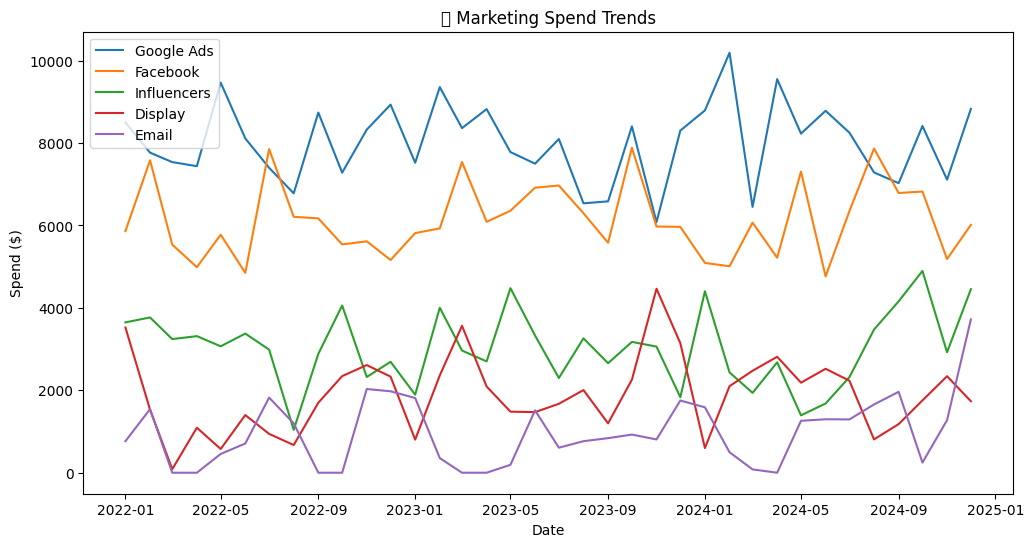

In [12]:
# Marketing spend trends
plt.figure(figsize=(12, 6))
for channel in df['channel'].unique():
  subset = df[df['channel'] == channel]
  plt.plot(subset['date'], subset['spend'], label=channel)

plt.title("📢 Marketing Spend Trends")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Spend ($)')
plt.show()

In [13]:
fig = px.line(df, x='date', y='spend', color='channel',
              title='📢 Marketing Spend Trends')
fig.update_layout(xaxis_title='Date',
                  yaxis_title='Spend ($)',
                  template='plotly_white')
fig.show()

##### -------------------------------
##### 🧠 Feature Engineering
##### -------------------------------

In [14]:
df['month'] = df['date'].dt.month

In [15]:
df['channel'].unique()

array(['Google Ads', 'Facebook', 'Influencers', 'Display', 'Email'],
      dtype=object)

In [16]:
pivot_df = df.pivot(index='date', columns='channel', values='spend').reset_index()

In [17]:
meta_cols = df[['date','total_revenue', 'month']].drop_duplicates()

In [18]:
final_df = pd.merge(pivot_df, meta_cols, on='date', how='left')

In [19]:
final_df['date'].dtype

dtype('<M8[ns]')

In [20]:
# Lagged features (carryover effect)
for col in ['Google Ads', 'Facebook', 'Influencers', 'Display', 'Email']:
  final_df[f"{col}_lag1"] = final_df[col].shift(1)

In [21]:
final_df.head()

,date,Display,Email,Facebook,Google Ads,Influencers,total_revenue,month,Google Ads_lag1,Facebook_lag1,Influencers_lag1,Display_lag1,Email_lag1
0,2022-01-01,3523.03,765.85,5861.74,8496.71,3647.69,51877.00,1,NaN,NaN,NaN,NaN,NaN
1,2022-02-01,1530.53,1542.56,7579.21,7765.86,3767.43,50088.90,2,8496.71,5861.74,3647.69,3523.03,765.85
2,2022-03-01,86.72,0.00,5534.27,7536.58,3241.96,51916.32,3,7765.86,7579.21,3767.43,1530.53,1542.56
3,2022-04-01,1091.98,0.00,4987.17,7437.71,3314.25,58675.37,4,7536.58,5534.27,3241.96,86.72,0.00
4,2022-05-01,575.25,455.62,5774.22,9465.65,3067.53,58135.57,5,7437.71,4987.17,3314.25,1091.98,0.00


In [22]:
# Adstock transformation
def adstock_transform(series, decay=0.5):
  result = []
  for i in range(len(series)):
    if i == 0:
      result.append(series.iloc[i])
    else:
      result.append(series.iloc[i] + decay * result[i-1])
  return result

In [23]:
for col in ['Google Ads', 'Facebook', 'Influencers', 'Display', 'Email']:
  final_df[f"{col}_adstock"] = adstock_transform(final_df[col], decay=0.5)

In [24]:
final_df.head()

,date,Display,Email,Facebook,Google Ads,Influencers,total_revenue,month,Google Ads_lag1,Facebook_lag1,Influencers_lag1,Display_lag1,Email_lag1,Google Ads_adstock,Facebook_adstock,Influencers_adstock,Display_adstock,Email_adstock
0,2022-01-01,3523.03,765.85,5861.74,8496.71,3647.69,51877.00,1,NaN,NaN,NaN,NaN,NaN,8496.710000,5861.7400,3647.690000,3523.030000,765.850000
1,2022-02-01,1530.53,1542.56,7579.21,7765.86,3767.43,50088.90,2,8496.71,5861.74,3647.69,3523.03,765.85,12014.215000,10510.0800,5591.275000,3292.045000,1925.485000
2,2022-03-01,86.72,0.00,5534.27,7536.58,3241.96,51916.32,3,7765.86,7579.21,3767.43,1530.53,1542.56,13543.687500,10789.3100,6037.597500,1732.742500,962.742500
3,2022-04-01,1091.98,0.00,4987.17,7437.71,3314.25,58675.37,4,7536.58,5534.27,3241.96,86.72,0.00,14209.553750,10381.8250,6333.048750,1958.351250,481.371250
4,2022-05-01,575.25,455.62,5774.22,9465.65,3067.53,58135.57,5,7437.71,4987.17,3314.25,1091.98,0.00,16570.426875,10965.1325,6234.054375,1554.425625,696.305625


In [25]:
# Drop NA rows from lag/adstock
final_df.dropna(inplace=True)

In [26]:
final_df.head()

,date,Display,Email,Facebook,Google Ads,Influencers,total_revenue,month,Google Ads_lag1,Facebook_lag1,Influencers_lag1,Display_lag1,Email_lag1,Google Ads_adstock,Facebook_adstock,Influencers_adstock,Display_adstock,Email_adstock
1,2022-02-01,1530.53,1542.56,7579.21,7765.86,3767.43,50088.90,2,8496.71,5861.74,3647.69,3523.03,765.85,12014.215000,10510.08000,5591.275000,3292.045000,1925.485000
2,2022-03-01,86.72,0.00,5534.27,7536.58,3241.96,51916.32,3,7765.86,7579.21,3767.43,1530.53,1542.56,13543.687500,10789.31000,6037.597500,1732.742500,962.742500
3,2022-04-01,1091.98,0.00,4987.17,7437.71,3314.25,58675.37,4,7536.58,5534.27,3241.96,86.72,0.00,14209.553750,10381.82500,6333.048750,1958.351250,481.371250
4,2022-05-01,575.25,455.62,5774.22,9465.65,3067.53,58135.57,5,7437.71,4987.17,3314.25,1091.98,0.00,16570.426875,10965.13250,6234.054375,1554.425625,696.305625
5,2022-06-01,1399.36,708.31,4849.01,8110.92,3375.70,61891.28,6,9465.65,5774.22,3067.53,575.25,455.62,16396.133438,10331.57625,6492.727187,2176.572813,1056.462812


##### -------------------------------
##### 🎯 Define Features & Target
##### -------------------------------

In [27]:
features = [f"{col}_adstock" for col in ['Google Ads', 'Facebook', 'Influencers', 'Display', 'Email']]

X = final_df[features]
y = final_df['total_revenue']

##### -------------------------------
##### 🤖 Modeling
##### -------------------------------

In [28]:
tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=tscv)
ridge.fit(X, y)

RidgeCV(alphas=[0.1, 1.0, 10.0],
        cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None))

In [29]:
# Predict
preds = ridge.predict(X)
rmse = np.sqrt(mean_squared_error(y, preds))
print(f"📊 Ridge MMM -> RMSE: {rmse:.2f}")

📊 Ridge MMM -> RMSE: 6624.40


##### -------------------------------
##### 📈 Visualize Fit
##### -------------------------------

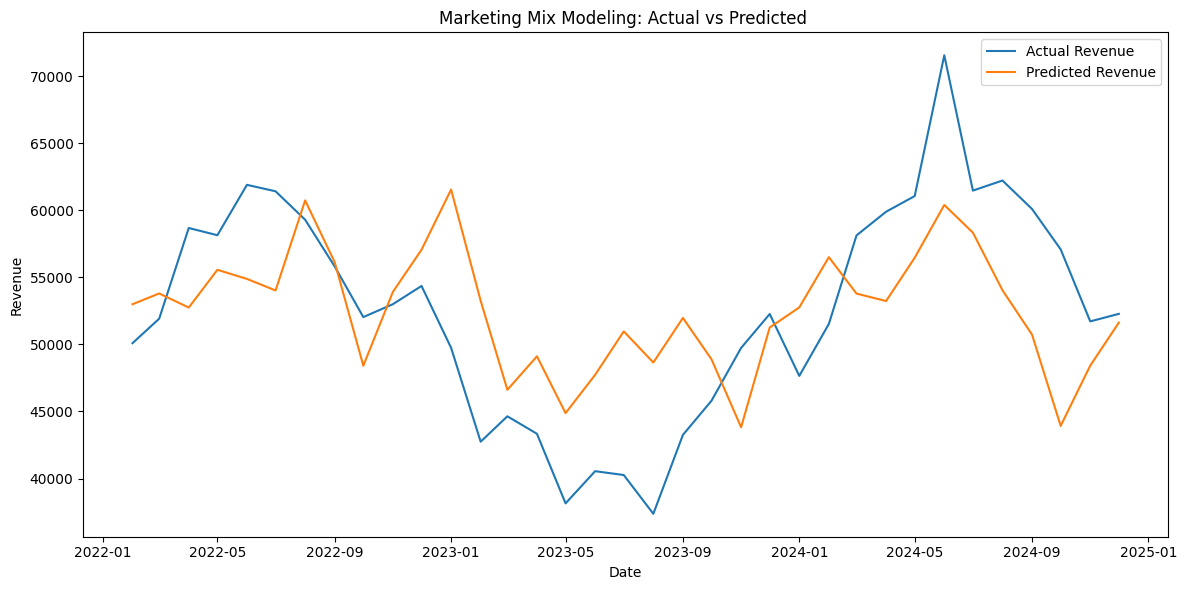

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(final_df['date'], y, label='Actual Revenue')
plt.plot(final_df['date'], preds, label='Predicted Revenue')
plt.title('Marketing Mix Modeling: Actual vs Predicted ')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
plot_df = final_df.copy()
plot_df['predicted'] = preds.round(2)

In [32]:
plot_df.head()

,date,Display,Email,Facebook,Google Ads,Influencers,total_revenue,month,Google Ads_lag1,Facebook_lag1,Influencers_lag1,Display_lag1,Email_lag1,Google Ads_adstock,Facebook_adstock,Influencers_adstock,Display_adstock,Email_adstock,predicted
1,2022-02-01,1530.53,1542.56,7579.21,7765.86,3767.43,50088.90,2,8496.71,5861.74,3647.69,3523.03,765.85,12014.215000,10510.08000,5591.275000,3292.045000,1925.485000,52992.85
2,2022-03-01,86.72,0.00,5534.27,7536.58,3241.96,51916.32,3,7765.86,7579.21,3767.43,1530.53,1542.56,13543.687500,10789.31000,6037.597500,1732.742500,962.742500,53796.47
3,2022-04-01,1091.98,0.00,4987.17,7437.71,3314.25,58675.37,4,7536.58,5534.27,3241.96,86.72,0.00,14209.553750,10381.82500,6333.048750,1958.351250,481.371250,52745.52
4,2022-05-01,575.25,455.62,5774.22,9465.65,3067.53,58135.57,5,7437.71,4987.17,3314.25,1091.98,0.00,16570.426875,10965.13250,6234.054375,1554.425625,696.305625,55559.37
5,2022-06-01,1399.36,708.31,4849.01,8110.92,3375.70,61891.28,6,9465.65,5774.22,3067.53,575.25,455.62,16396.133438,10331.57625,6492.727187,2176.572813,1056.462812,54880.05


In [33]:
# melt
melted = plot_df.melt(id_vars='date', value_vars=['total_revenue', 'predicted'],
                      var_name='Type', value_name='Revenue')

# Rename for -- legend labels
melted['Type'] = melted['Type'].replace({
  'total_revenue': 'Actual revenue',
    'predicted': 'Predicted revenue'
})

In [34]:
fig = px.line(melted, x='date', y='Revenue', color='Type',
              title='Marketing Mix Modeling: Actual vs Predicted')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Revenue',
    legend_title='Legend',
    template='plotly_white'
)

fig.show()

##### -------------------------------
##### 📊 Channel Contribution Analysis
##### -------------------------------

In [35]:
coef_df = pd.DataFrame(
    {
        'Channel': features,
        'Contribution': ridge.coef_
    }
).sort_values(by='Contribution', ascending=False)

fig = px.bar(coef_df, x='Contribution', y='Channel',
             title='📢 Marketing Channel Contributions to Revenue')
fig.update_layout(
    yaxis_title='',
    template='plotly_white'
)
fig.show()

In [36]:
pd.DataFrame(
    {
        'Channel': features,
        'Contribution': ridge.coef_
    }
).sort_values(by='Contribution', ascending=False)

,Channel,Contribution
4,Email_adstock,1.724459
0,Google Ads_adstock,0.907081
1,Facebook_adstock,-1.286958
3,Display_adstock,-1.828348
2,Influencers_adstock,-3.170613


##### -------------------------------
##### 💡 ROI Estimation
##### -------------------------------

In [37]:
for col in ['Google Ads', 'Facebook', 'Influencers', 'Display', 'Email']:
  contribution = ridge.coef_[features.index(f"{col}_adstock")] * final_df[f"{col}_adstock"].mean()
  spend = final_df[col].mean()
  roi = contribution / spend
  print(f"📈 Estimated ROI for {col}: {roi:.2f}")

📈 Estimated ROI for Google Ads: 1.79
📈 Estimated ROI for Facebook: -2.54
📈 Estimated ROI for Influencers: -6.21
📈 Estimated ROI for Display: -3.65
📈 Estimated ROI for Email: 3.24
